# Data preparation

## Data loading

In [10]:
#
# Data Loading
#

from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 133)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dataset/train')
valid_files, valid_targets = load_dataset('dataset/val')
test_files, test_targets = load_dataset('dataset/test')

# load list of categories names
category_names = [item[14:-1] for item in sorted(glob("dataset/train/*/"))]

# print statistics about the dataset
print('There are %d total categories:' % len(category_names), str(category_names))
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

There are 2 total categories: ['NORMAL', 'PNEUMONIA']
There are 5856 total images.

There are 5216 training images.
There are 16 validation images.
There are 624 test images.


## Data inspection

In [11]:
#
# Data Inspection
#

import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline           

from PIL import Image                  

image_size = 224
random_img = Image.fromarray(np.random.rand(image_size, image_size) * 255)
random_img = random_img.convert('RGB')

def path_to_image(img_path):
    final_img = random_img.copy()  # random content image (to ensure the proper size)
    img = Image.open(img_path)
    img.thumbnail((image_size, image_size), Image.LANCZOS)  # rescaled image (preserves aspect ratio)
    offset = (int((image_size - img.width)/2), int((image_size - img.height)/2))
    final_img.paste(img, offset)
    return final_img

# display some sample images
for i in range(0):
    # original image
    print(train_files[i])
    plt.imshow(cv2.cvtColor(cv2.imread(train_files[i]), cv2.COLOR_BGR2RGB))
    plt.show()
    # show final image
    plt.imshow(cv2.cvtColor(np.asarray(path_to_image(train_files[i])), cv2.COLOR_BGR2RGB))
    plt.show()
    

## Data preprocessing

In [26]:
#
# Resizing and centering images
#
# Note: the original 16 validation images go into the training folder
#       a bigger validation dataset is created out of the training folder
#

import shutil, os, random

valid_perc = 15
test_perc = 15

try:
    os.mkdir('dataset/resized')
    for folder in ['train', 'valid', 'test']:
        os.mkdir('dataset/resized/' + folder)
        os.mkdir('dataset/resized/' + folder + '/NORMAL')
        os.mkdir('dataset/resized/' + folder + '/PNEUMONIA')
    print('Created resized/ folder hierarchy...')

    for infile in np.hstack([train_files, valid_files, test_files]):
        outfile = infile.replace('train', 'resized/train').replace('val', 'resized/train').replace('test', 'resized/train')
        path_to_image(infile).save(outfile)
    print('Copied preprocessed images...')

    for category in category_names:
        train_files = glob("dataset/resized/train/" + category + "/*")
        num_files = len(train_files)
        # validation files
        num_valid_files = int(round(num_files * valid_perc / 100))
        valid_files = random.sample(train_files, num_valid_files)
        for filename in valid_files:
            shutil.move(filename, filename.replace('train', 'valid'))
        # test files
        train_files = glob("dataset/resized/train/" + category + "/*")
        num_test_files = int(round(num_files * test_perc / 100))
        test_files = random.sample(train_files, num_test_files)
        for filename in test_files:
            shutil.move(filename, filename.replace('train', 'test'))
    print('Rearranged train, validation and test datasets into {}:{}:{} ratio...'.format(
        int(100-valid_perc-test_perc), int(valid_perc), int(test_perc)))
    # load train, test, and validation datasets
    train_files, train_targets = load_dataset('dataset/resized/train')
    valid_files, valid_targets = load_dataset('dataset/resized/valid')
    test_files, test_targets = load_dataset('dataset/resized/test')
except FileExistsError:
    print('Rearranged dataset already exists - nothing to do.')

Rearranged dataset already exists - nothing to do.


# Transfer learning

In [15]:
from tensorflow.python.keras.applications import mobilenet
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()

model.add(mobilenet_model)
for layer in model.layers:
    layer.trainable=False

# custom layers on top

categorical_or_binary = 'binary'  # binary or categorical

model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))

if categorical_or_binary == 'binary':
    # Dense 1-class output - used to plot ROC curve
    model.add(Dense(1, activation='sigmoid'))
else:
    # Dense for 2-class classification using SoftMax activation
    model.add(Dense(len(category_names), activation='softmax'))

#from tensorflow.python.keras import optimizers
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss=(categorical_or_binary + '_crossentropy'), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, None, 1024)  0         
_________________________________________________________________
dense_8 (Dense)              (None, None, None, 512)   524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, None, 512)   0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
__________

In [16]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = int(0.5*(100 - valid_perc))
BATCH_SIZE_VALIDATION = int(0.5 * valid_perc)

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'dataset/resized/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode=categorical_or_binary)

validation_generator = data_generator.flow_from_directory(
        'dataset/resized/valid',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode=categorical_or_binary)

predict_generator = data_generator.flow_from_directory(
        'dataset/resized/test',
        target_size=(image_size, image_size),
        batch_size=50,  # 100 causes ResourceExhaustedError
        class_mode=categorical_or_binary)

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


In [17]:
# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 15  # probably 15 is maximum useful...
EARLY_STOP_PATIENCE = 5

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = int(100 - valid_perc - test_perc)
STEPS_PER_EPOCH_VALIDATION = int(valid_perc)

# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath='saved_models/best_resnet50.hdf5',
                                  monitor='val_loss', save_best_only=True, mode='auto')

fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

model.load_weights("saved_models/best_resnet50.hdf5")

Epoch 1/15
85/85 [==============================] - 61s 717ms/step - loss: 0.2835 - acc: 0.8757 - val_loss: 0.2192 - val_acc: 0.8952
Epoch 2/15
85/85 [==============================] - 55s 649ms/step - loss: 0.1452 - acc: 0.9459 - val_loss: 0.1220 - val_acc: 0.9524
Epoch 3/15
85/85 [==============================] - 56s 658ms/step - loss: 0.1351 - acc: 0.9441 - val_loss: 0.0933 - val_acc: 0.9714
Epoch 4/15
85/85 [==============================] - 55s 649ms/step - loss: 0.1503 - acc: 0.9405 - val_loss: 0.0798 - val_acc: 0.9714
Epoch 5/15
85/85 [==============================] - 56s 655ms/step - loss: 0.1096 - acc: 0.9590 - val_loss: 0.0900 - val_acc: 0.9714
Epoch 6/15
85/85 [==============================] - 55s 647ms/step - loss: 0.0991 - acc: 0.9633 - val_loss: 0.0854 - val_acc: 0.9810
Epoch 7/15
85/85 [==============================] - 57s 665ms/step - loss: 0.0968 - acc: 0.9633 - val_loss: 0.0785 - val_acc: 0.9714
Epoch 8/15
85/85 [==============================] - 59s 698ms/step - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


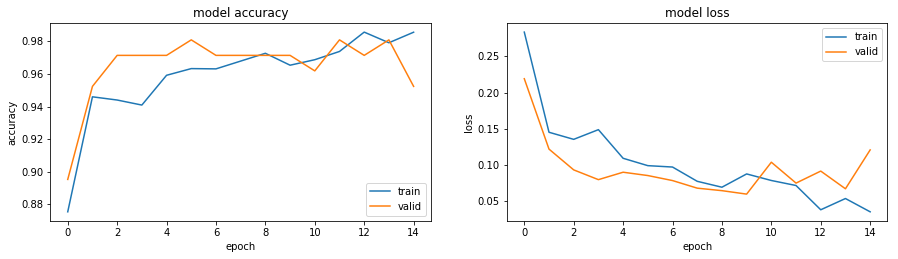

In [18]:
print(fit_history.history.keys())

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [27]:
predictions = [predicted[0] for predicted in model.predict_generator(predict_generator)]
y_pred = np.round(predictions).astype('int')
y_test = np.argmax(test_targets, axis=1)
print('Debug:', y_pred[:20], len(y_pred))
print('Debug:', y_test[:20], len(y_test))

Debug: [1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0] 878
Debug: [1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1] 878


In [28]:
# report test accuracy
test_accuracy = 100 * np.sum(y_pred==y_test) / len(y_pred)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 61.1617%


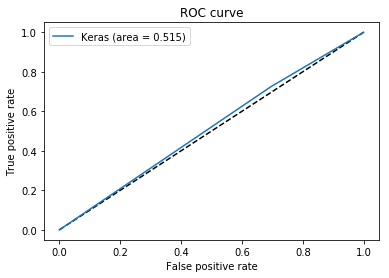

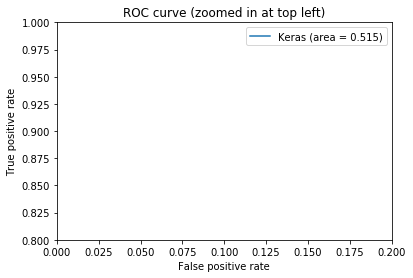

In [29]:
#
# ROC curve
#

from sklearn.metrics import roc_curve, auc

#y_pred = predictions.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()